# ARMA vs. GARCH vs. ARMA GARCH
In this Notebook we will do some basic comparison between classical models.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

seed=99
random.seed(seed)
np.random.seed(seed)

## Prepare data

In [2]:
morocco = pd.read_csv("../data/processed/morocco_processed.csv")
#usa = pd.read_csv("../data/processed/")
#paraguay = pd.read_csv("../data/processed")

In [3]:
#morocco.drop(['Unnamed: 0'], axis=1, inplace=True)
morocco.set_index('DateTime', inplace=True)

In [79]:
morocco.head()

,Consumption,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
DateTime,,,,,,
2017-01-01 00:00:00,398860.62358,6.196833,75.066667,0.081833,0.063500,0.098833
2017-01-01 01:00:00,346671.15726,5.548833,77.583333,0.082000,0.056833,0.112500
2017-01-01 02:00:00,312539.28984,5.054333,78.933333,0.082333,0.063000,0.129167
2017-01-01 03:00:00,293486.68529,5.004333,77.083333,0.082833,0.059833,0.141000
2017-01-01 04:00:00,286287.83008,5.097667,74.050000,0.082333,0.058000,0.122833


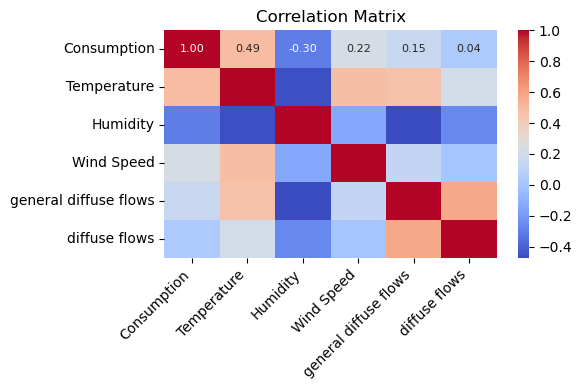

In [5]:
# Correlation matrix
correlation_matrix = morocco.corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.yticks(rotation=0)  # Ensure y labels are horizontal for clarity
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

A correlation of 0.49 between Consumption and Temperature suggests there is a moderate positive linear relationship between the two variables. In the context of your SARIMAX model, which includes Temperature as an exogenous variable, this means that changes in temperature are moderately associated with changes in energy consumption. As the temperature increases, energy consumption tends to increase as well, or vice versa, but the relationship isn't so strong that changes in temperature would predict changes in consumption perfectly.

The moderate correlation justifies the inclusion of temperature as an exogenous variable in the SARIMAX model. It likely provides useful information that helps explain some of the variation in consumption that is not captured by the time series model alone.

## Preprocess
Both ARMA and GARCH models require stationarity. Use unit root tests like the Augmented Dickey-Fuller (ADF) test to check for stationarity. This might require differencing the series or transforming it (e.g., logarithmic transformation).

Text(0.5, 1.0, 'Morocco Consumption')

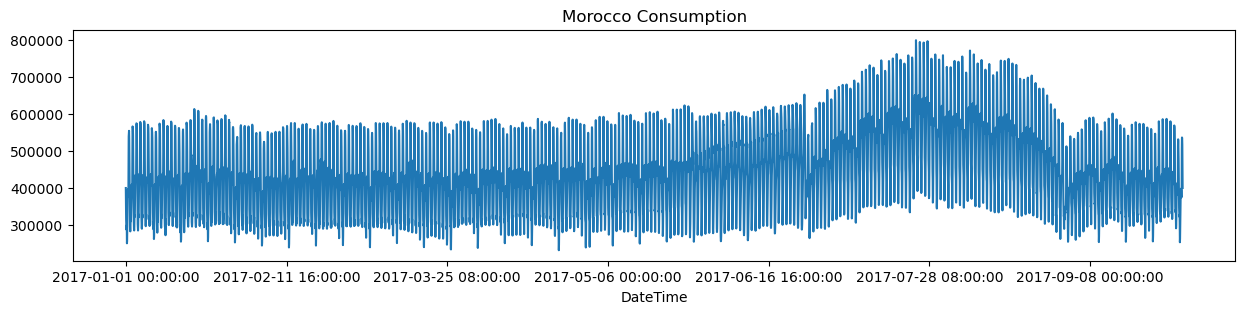

In [6]:
morocco['Consumption'][:-2160].plot(figsize=(15,3))
plt.title('Morocco Consumption')

Text(0.5, 1.0, 'Morocco Temperature')

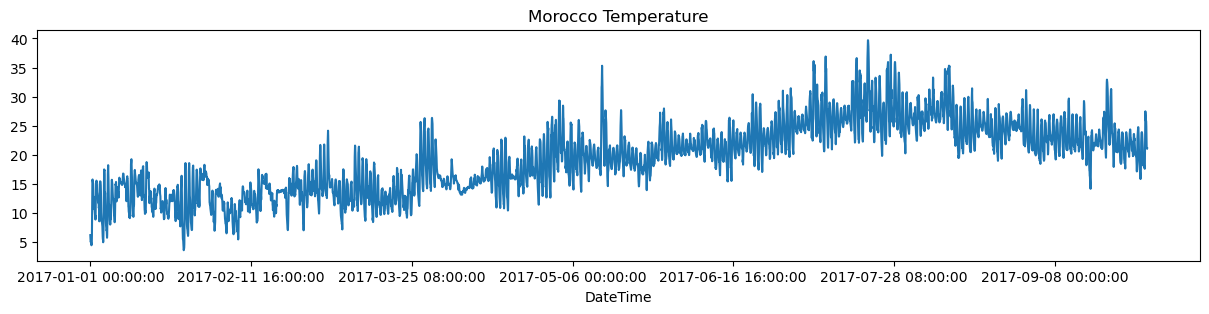

In [7]:
morocco['Temperature'][:-2160].plot(figsize=(15,3))
plt.title('Morocco Temperature')

The data is not stationary as expected. The mean and std is not constant over time. Use differencing to make it stationary.

Differencing is a common technique used to transform a non-stationary time series into a stationary one by removing trends and seasonal structures. This process is often necessary before fitting models like ARIMA or SARIMAX, as these models require stationarity to produce reliable forecasts.

You can apply first differencing directly with pandas to remove trends. If your data has a seasonal pattern, you might need seasonal differencing as well:

In [8]:
# differencing to remove trends
diff = pd.DataFrame()
diff['Consumption_diff'] = morocco['Consumption'][:-2160].diff()

# Seasonal difference
seasonal_period = 7  # weekly seasonality in daily data
diff['Seasonal_Difference'] = morocco['Consumption'][:-2160].diff(periods=seasonal_period)

In [9]:
diff['Temperature_diff'] = morocco['Temperature'][:-2160].diff()

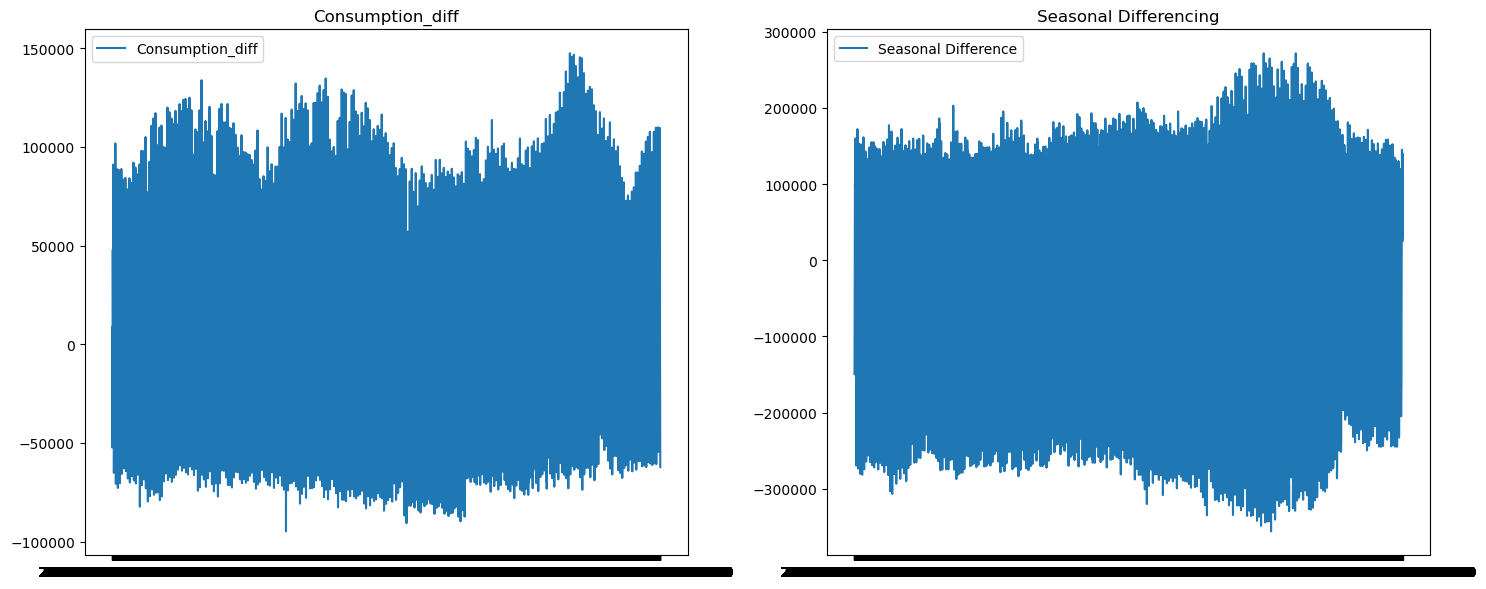

In [10]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(diff['Consumption_diff'], label='Consumption_diff')
plt.title('Consumption_diff')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diff['Seasonal_Difference'], label='Seasonal Difference')
plt.title('Seasonal Differencing')
plt.legend()

plt.tight_layout()
plt.show()

After differencing, it's advisable to perform a statistical test to confirm stationarity. The Augmented Dickey-Fuller (ADF) test is commonly used:
* If the p-value is less than a typical threshold (e.g., 0.05), you can reject the null hypothesis that the time series is non-stationary.
* Depending on the test results, you may need to apply additional differencing or alter the differencing interval.

In [11]:
# Test on original data
adf_test = adfuller(morocco['Consumption'].dropna())  # Dropping NA values as differencing introduces them
print("ADF Statistic (Original):", adf_test[0])
print("p-value (Original):", adf_test[1])

ADF Statistic (Original): -2.573768830541221
p-value (Original): 0.09854080867956366


In [12]:
# Test on first differenced data
adf_test = adfuller(diff['Consumption_diff'].dropna())  # Dropping NA values as differencing introduces them
print("ADF Statistic (First Difference):", adf_test[0])
print("p-value (First Difference):", adf_test[1])

ADF Statistic (First Difference): -18.663933470503686
p-value (First Difference): 2.0467502437982986e-30


#### Interpret
The results of your Augmented Dickey-Fuller (ADF) test are quite clear and indicate strong evidence of stationarity in your differenced time series data. Here’s a breakdown of what these results mean:
* ADF Statistic: -18.663933470503686. This statistic is far more negative than typical critical values (e.g., -3.5, -2.9, -2.6) used in the test for different levels of confidence. The more negative this statistic, the stronger the rejection of the hypothesis that the series has a unit root (i.e., is non-stationary).
* p-value: 2.0467502437982986 * 10^-30. This p-value is extremely small (practically zero), far below any conventional significance level (e.g., 0.05 or 5%). A low p-value like this strongly rejects the null hypothesis of non-stationarity.

Differencing simplifies the model by removing the need to include an integrated (I) term in the SARIMAX model, as indicated by the 0 in the model order (SARIMAX(1, 0, 1)). This can be advantageous for model interpretability.

## Model specification
Specify different lags. Use tools like ACF (Autocorrelation Function), PACF (Partial Autocorrelation Function), and AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) for determining the appropriate lag lengths/ orders (p, d, q).

In [4]:
# Prepare data
dataset_name='morocco'
X = morocco['Temperature']#.to_numpy()#.values
y = morocco['Consumption']#.to_numpy()#.values
horizon=2160 # 90 days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=horizon, random_state=seed, shuffle=False)

In [37]:
# Set up differenced data
X_train_diff = X_train.diff().dropna()
X_test_diff = X_test.diff().dropna()
y_train_diff = y_train.diff().dropna()
y_test_diff = y_test.diff().dropna()

print(X_train_diff.isnull().sum())
print(X_test_diff.isnull().sum())
print(y_train_diff.isnull().sum())
print(y_test_diff.isnull().sum())

print(X_train_diff.shape)
print(X_test_diff.shape)
print(y_train_diff.shape)
print(y_test_diff.shape)

0
0
0
0
(6575,)
(2159,)
(6575,)
(2159,)


In [58]:
X_test[1:]

DateTime
2017-10-02 01:00:00    19.923333
2017-10-02 02:00:00    19.815000
2017-10-02 03:00:00    19.898333
2017-10-02 04:00:00    19.733333
2017-10-02 05:00:00    19.331667
                         ...    
2017-12-30 19:00:00     9.453333
2017-12-30 20:00:00     9.041667
2017-12-30 21:00:00     8.011667
2017-12-30 22:00:00     7.598333
2017-12-30 23:00:00     6.877500
Name: Temperature, Length: 2159, dtype: float64

In [59]:
X_test_diff

DateTime
2017-10-02 01:00:00   -0.546667
2017-10-02 02:00:00   -0.108333
2017-10-02 03:00:00    0.083333
2017-10-02 04:00:00   -0.165000
2017-10-02 05:00:00   -0.401667
                         ...   
2017-12-30 19:00:00   -1.318333
2017-12-30 20:00:00   -0.411667
2017-12-30 21:00:00   -1.030000
2017-12-30 22:00:00   -0.413333
2017-12-30 23:00:00   -0.720833
Name: Temperature, Length: 2159, dtype: float64

### AutoRegressive Moving Average (ARMA)
Focuses on capturing the autocorrelation in the mean of the time series. You specify orders p (autoregression) and q (moving average). Determine the orders using ACF and PACF plots.

The math behind ARMA: https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3/

SARMIMAX: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

### SARIMAX
Using the SARIMAX model (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables model) is an excellent choice, especially if your energy consumption data exhibits seasonal patterns or if you want to include external variables (exogenous factors) that could influence the model. SARIMAX extends the ARIMA model to include seasonal components and external variables, making it more flexible for more complex datasets.

In [5]:
# Adjust p, d, q values based on your data analysis (e.g., ACF, PACF plots, stationarity tests, autocorrelation plots)
def create_sarimax_model(endog, exog=None, **kwargs):
    sarimax_model = SARIMAX(endog, exog, freq='H', **kwargs)
    sarimax_model = sarimax_model.fit(disp=False) # disp=False to avoid verbose output
    
    return sarimax_model

In [83]:
sarimax22 = create_sarimax_model(y_train, X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False) # 24hrs=day
print(f'AIC: {sarimax22.aic:.0f} BIC: {sarimax22.bic:.0f}')

AIC: 149569 BIC: 149610


In [77]:
sarimax22 = create_sarimax_model(y_train, X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=True) # 24hrs=day
print(f'AIC: {sarimax22.aic:.0f} BIC: {sarimax22.bic:.0f}')

AIC: 150143 BIC: 150184


In [20]:
%%time
# sarimax without differenced data, exog temperature and daily seasonal orders
sarimax = create_sarimax_model(y_train, X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
#print(results.summary())
print('Result using the last 90 days:')
print(f'AIC: {sarimax.aic:.0f} BIC: {sarimax.bic:.0f}')
#results.plot_diagnostics(figsize=(15, 12))
#plt.show()
print('')

sarimax = create_sarimax_model(y, X, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
print('Result using the whole dataset:')
print(f'AIC: {sarimax.aic:.0f} BIC: {sarimax.bic:.0f}')
print('')

Result using the last 90 days:
AIC: 150143 BIC: 150184

Result using the whole dataset:
AIC: 199191 BIC: 199234

CPU times: user 40.3 s, sys: 1min 7s, total: 1min 48s
Wall time: 14 s


s=24 (day), AIC: 150,143 BIC: 150,184  
s=24 (day), enforce_stationarity=False: AIC: 149,569 BIC: 149,610  
s=168 (week), AIC: 154,446 BIC: 154,487. takes 23min 55s to run

#### Seasonal component of weekly cycle (s=198):
* AIC: 154446 BIC: 154487
* CPU times: user 2h 58min 40s, sys: 3min 23s, total: 3h 2min 4s
* Wall time: 23min 55s

On Kaggle. It took 45 min and got about the same AIC values.

In [8]:
%%time
sarimax22 = create_sarimax_model(y_train, X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 198))
print(f'AIC: {sarimax22.aic:.0f} BIC: {sarimax22.bic:.0f}')

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


AIC: 154446 BIC: 154487
CPU times: user 2h 58min 40s, sys: 3min 23s, total: 3h 2min 4s
Wall time: 23min 55s


In [ ]:
%%time
sarimax22 = create_sarimax_model(y_train, X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 198), enforce_stationary=False)
print(f'AIC: {sarimax22.aic:.0f} BIC: {sarimax22.bic:.0f}')

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [84]:
#dimensions
print(y_train.shape)
print(y_test.shape)
print(sarimax.resid.shape)

(6576,)
(2160,)
(6576,)


Using the y_train and X_train gives a much lower AIC and BIC value:
* AIC: 155,018 BIC: 155,058

With the whole data we get:
* AIC: 205,563 BIC: 205,605

#### SARIMAX Configurations testing

In [6]:
%%time

# Initialize variables to store best AIC, BIC, and corresponding model
best_aic = np.inf
best_bic = np.inf
best_model = None

configurations = [
    {'name': 'SARIMAX with differenced Consumption',
     'endog': y_train.diff().dropna(),
     'exog': None,
     'order': (1, 0, 1),
     'seasonal_order': (0, 0, 0, 0)},
    {'name': 'SARIMAX with differenced Consumption + seasonal orders',
     'endog': y_train.diff().dropna(),
     'exog': None,
     'order': (1, 0, 1),
     'seasonal_order': (1, 0, 1, 24),
     'enforce_stationarity': False},
    {'name': 'SARIMAX with differenced Consumption + differenced Temperature',
     'endog': y_train.diff().dropna(),
     'exog': X_train.diff().dropna(),
     'order': (1, 0, 1),
     'seasonal_order': (0, 0, 0, 0)},
    {'name': 'SARIMAX with differenced Consumption + differenced Temperature + seasonal orders',
     'endog': y_train.diff().dropna(),
     'exog': X_train.diff().dropna(),
     'order': (1, 0, 1),
     'seasonal_order': (1, 0, 1, 24)},
    {'name': 'SARIMAX without differenced Consumption',
     'endog': y_train,
     'exog': None,
     'order': (1, 0, 1),
     'seasonal_order': (0, 0, 0, 0)},
    {'name': 'SARIMAX without differenced Consumption + seasonal orders',
     'endog': y_train,
     'exog': None,
     'order': (1, 0, 1),
     'seasonal_order': (1, 0, 1, 24),
     'enforce_stationarity': False},
    {'name': 'SARIMAX without differenced Consumption + Temperature',
     'endog': y_train,
     'exog': X_train,
     'order': (1, 0, 1),
     'seasonal_order': (0, 0, 0, 0)},
    {'name': 'SARIMAX without differenced Consumption + Temperature + seasonal orders',
     'endog': y_train,
     'exog': X_train,
     'order': (1, 0, 1),
     'seasonal_order': (1, 0, 1, 24)}
]

for config in configurations:
    print(config['name'])
    
    sarimax = create_sarimax_model(**config)
    aic, bic = sarimax.aic, sarimax.bic
    print(f'   AIC: {aic:.0f} BIC: {bic:.0f}')
    
    # Update best model if AIC or BIC is lower than the current best
    if aic < best_aic or bic < best_bic:
        best_aic = min(aic, best_aic)
        best_bic = min(bic, best_bic)
        best_model = sarimax

# Highlight the lowest AIC and BIC values
print('\nBest Model:')
print(f'   AIC: {"**" if best_aic == min(best_aic, best_bic) else ""}{best_aic:.0f} BIC: {"**" if best_bic == min(best_aic, best_bic) else ""}{best_bic:.0f}')
print('\n')

SARIMAX with differenced Consumption
   AIC: 154078 BIC: 154098
SARIMAX with differenced Consumption + seasonal orders


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 147366 BIC: 147400
SARIMAX with differenced Consumption + differenced Temperature


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 154168 BIC: 154195
SARIMAX with differenced Consumption + differenced Temperature + seasonal orders


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 137069 BIC: 137110
SARIMAX without differenced Consumption


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 154616 BIC: 154636
SARIMAX without differenced Consumption + seasonal orders


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 147819 BIC: 147853
SARIMAX without differenced Consumption + Temperature


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 155182 BIC: 155209
SARIMAX without differenced Consumption + Temperature + seasonal orders


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


   AIC: 150143 BIC: 150184

Best Model:
   AIC: **137069 BIC: 137110


CPU times: user 1min 33s, sys: 2min 14s, total: 3min 47s
Wall time: 35.3 s


In [7]:
print(best_model.aic)
print(sarimax.aic)

137069.29782017786
150143.07625695228


endog=y_train, exog=None, s=24, enforce_stationarity=False: AIC: 147,819 BIC: 147,853  
endog=y_train, exog=X_train, s=24: AIC: 150,143 BIC: 150,184  
endog=y_train diff, exog=X_train diff, s=24: AIC: 137,069 BIC: 137,110

After running all the configurations. The best results come from the:  
* SARIMAX with differenced Consumption + differenced Temperature + seasonal orders

Differencing still has a huge impact on aic values

#### Diagnostic summary of differenced Consumption
Coefficiants:
* SARIMAX(1, 0, 1), which means the model includes one autoregressive term and one moving average term. 
* There's no indication of seasonal components in the summary, which suggests that either there's no seasonality in the data or it wasn't included in this particular model.
* 6576 observations. Why isnt it only 2160/ 90 days?
* Log likelihood is a big negative number. This measures the models goodnes of fit
* AIC and BIC used for model comparison. lower values generally indicate better model fit when comparing models of the same data. These values are high.
* ar.L1 (autoregressive coeff) is significant high > 0.05
* ma.L1 (moving avg coeff) is significant high > 0.05
* sigma2: Represents the variance of the residuals. Its estimate seems quite large and may indicate high volatility in the data or potentially large outliers or scale of the data.  

Residual diagnostics:
* Ljung-Box Test: The Ljung-Box Q statistic is not significant (p = 0.49), suggesting that there's no autocorrelation in the residuals, which is good.
* Heteroskedasticity: The p-value for the heteroskedasticity test is 1.08, indicating no significant heteroskedasticity in the residuals.
* Jarque-Bera Test: The test statistic is very large (2190.39), and the p-value is 0.00, indicating that the residuals do not follow a normal distribution. This could be a concern as it violates one of the assumptions of the model.
* Skew: The skew is 0.56, suggesting a slight skew in the distribution of residuals, but not extreme.

#### Diagnostic summary of non-stationary data with Consumption and exog Temperature with seasonal orders
* The SARIMAX(1, 0, 1)x(1, 0, 1, 7) indicates a non-seasonal ARIMA component with one autoregressive and one moving average term, and a seasonal component with the same structure and a periodicity of 7, which might correspond to weekly seasonality in daily data.
* Better fit, as AIC and BIC are lower.
* Temperature: The coefficient is quite significant with a large value (2.149e+04), indicating a strong relationship between temperature and consumption.
* AR and MA Terms: All the estimated coefficients for the autoregressive and moving average parts, both seasonal and non-seasonal, are statistically significant (p-values are 0.000), suggesting these terms are relevant in explaining the time series data.

Residual diagnostics:
* Ljung-Box Test: The test statistic is 82.62 with a p-value of 0.00, which indicates that there is significant autocorrelation at lag 1 in the model residuals, contradicting the assumption that residuals should be independently distributed.
* Heteroskedasticity: The p-value for the heteroskedasticity test is 0.80, indicating there is no significant heteroskedasticity in the residuals.
* Jarque-Bera Test: The test statistic is quite high (5091.61), and the p-value is 0.00, indicating that the residuals are not normally distributed. The skewness and kurtosis values also confirm the residuals are not following a normal distribution.

The lack of normality in the residuals (according to the Jarque-Bera test) could be problematic, especially if you are relying on standard errors and confidence intervals derived under the assumption of normally distributed errors.
* examine the residuals more closely. Look at the residual plots to identify any patterns or outliers

The significant Ljung-Box statistic suggests that the model may not be adequately capturing all of the autocorrelation in the data. This could be due to model mis-specification or the presence of non-linear relationships that aren't being captured by the SARIMAX model.
* add more lags or exploring different seasonalities.

#### Improvements
* perform residual analysis to check for autocorrelation, non-normality, and any patterns left in the residuals, which could suggest model inadequacies or opportunities for improvement.

#### SARIMAX Predictive Analysis

In [93]:
print(y_train.shape)
print(X_train.shape)
print(sarimax_y_pred.shape)
print(y_test.shape)
print(X_test.shape)

(6576,)
(6576,)
(6575,)
(2160,)
(2160,)


In [38]:
print(y_test.diff().dropna().shape)

(2159,)


In [43]:
# predict 90 days with one of the other models (the one with aic 150,143)
sarimax_y_pred = sarimax.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)

sarimax_mape = mean_absolute_percentage_error(y_test, sarimax_y_pred)
sarimax_mae = mean_absolute_error(y_test, sarimax_y_pred)
sarimax_r2 = r2_score(y_test, sarimax_y_pred)
print(f'{dataset_name}, MAE: {sarimax_mae:.2f}, MAPE: {sarimax_mape:.3f}, R2: {sarimax_r2:.3f}')

morocco, MAE: 78884.55, MAPE: 0.199, R2: -0.510


In [48]:
print(sarimax_y_pred.shape)
print(y_test.shape)

(2160,)
(2160,)


In [49]:
best_sarimax = create_sarimax_model(endog=y_train_diff, exog=X_train_diff, order=(1,0,1), seasonal_order=(1,0,1,24))

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [53]:
print(y_train_diff.shape)
print(X_train_diff.shape)
print(X_test_diff.shape)
print(y_test_diff.shape)

(6575,)
(6575,)
(2159,)
(2159,)


In [74]:
X_test_diff.values.reshape(-1, 1).shape

(2159, 1)

In [76]:
# predict 90 days with best sarimax model
# remember to make the test data stationary
# start=X_test_diff.index[0], end=X_test_diff.index[-1], 
sarimax_y_pred = best_sarimax.predict(exog=X_test_diff.values.reshape(-1, 1))

sarimax_mape = mean_absolute_percentage_error(y_test_diff, sarimax_y_pred)
sarimax_mae = mean_absolute_error(y_test_diff, sarimax_y_pred)
sarimax_r2 = r2_score(y_test_diff, sarimax_y_pred)
print(f'{dataset_name}, MAE: {sarimax_mae:.2f}, MAPE: {sarimax_mape:.3f}, R2: {sarimax_r2:.3f}')

ValueError: Provided exogenous values are not of the appropriate shape. Required (2160, 1), got (2159,).

sarimax with whole input y and X, tested on X_test:
* morocco, MAE: 78 884.55, MAPE: 0.199, R2: -0.510

SARIMAX with y_train, X_train, tested on X_test
* morocco, MAE: 301 643.74, MAPE: 0.767, R2: -12.935

While AIC (Akaike Information Criterion) is a useful metric for model selection based on goodness of fit and complexity, it does not directly measure predictive accuracy. Therefore, it's possible for a model with the best AIC value to perform worse in terms of metrics like MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and R-squared when compared to other models.

Potential reasons:
* Overfitting: The model with the best AIC might be overfitting the training data, capturing noise or outliers that do not generalize well to the test data. This can lead to poor performance on unseen data, resulting in higher errors.
* Model misspecification: Another model might be better
* Assumptions: SARIMAX makes certain assumption about the underlying data, such as linearity and stationarity.

#### SARIMAX Hyperparameter Tuning

Hyperparameter tuning for SARIMAX models involves selecting the optimal values for parameters

Parameters to tune:
* autoregressive (p), differences (d), moving average (q) for non-seasonal ARIMA component.
* seasonal order (P, D, Q, s) for the seasonal ARIMA components.

The choice of s=168 for the seasonal period likely contributes to the longer runtime.

In SARIMAX models, the seasonal period (s) specifies the number of observations in each seasonal cycle. In your case, s=168 implies that the data has a weekly seasonal pattern, assuming the data is hourly with 24 hours in a day and 7 days in a week.

A seasonal period of 168 means that the model needs to estimate parameters for each hour within the weekly cycle. This increases the complexity of the model and the number of parameters that need to be estimated, which in turn can lead to longer fitting times, especially if the dataset is large.

When choosing the seasonal period, it's important to strike a balance between capturing the seasonal patterns in the data and computational efficiency. If the seasonal period is too long, it can increase the computational burden of the model without necessarily providing significant improvements in forecast accuracy.

You might consider adjusting the seasonal period (s) based on domain knowledge or by experimenting with different values to find a balance between model complexity and computational efficiency. Additionally, if the dataset exhibits multiple seasonal patterns (e.g., daily and weekly), you might need to use multiple seasonal periods or more sophisticated modeling techniques to capture these patterns effectively.

In [59]:
X_train.shape

(6576,)

In [ ]:
%%time
from itertools import product
import statsmodels.api as sm

# Define the grid of hyperparameters
p = range(0, 3)  # Autoregressive order
d = range(0, 2)  # Differencing order
q = range(0, 3)  # Moving average order
P = range(0, 2)  # Seasonal autoregressive order
D = range(0, 2)  # Seasonal differencing order
Q = range(0, 2)  # Seasonal moving average order
s = [24]         # Seasonal period (assuming hourly data)

# total combinations being tried: x*x*x*x*x=
# May try to do it parallelly with joblib
# https://github.com/HCGrit/MachineLearning-iamJustAStudent/tree/master/Demo-Parallel_Grid_Search_SARIMAX

# Create a grid of all possible combinations of hyperparameters
param_grid = product(p, d, q, P, D, Q, s)

# Initialize variables to store best AIC, best model, and best hyperparameters
best_aic = np.inf
best_model = None
best_params = None

# Split the dataset into training and validation sets: Just use the split from before

#train_size = int(len(y_train) * 0.8)
#train_data = y_train[:train_size]
#val_data = y_train[train_size:]

# Perform grid search
# Use cross-validation or a validation set to evaluate the performance of each parameter combination
# on a chosen metric (e.g., AIC, BIC, RMSE). 
# Select the parameter combination that performs best according to the chosen metric.

for param in param_grid:
    try:
        # Fit SARIMAX model
        sarimax = sm.tsa.SARIMAX(train_data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], param[6]), enforce_stationarity=False, enforce_invertibility=False)
        results = sarimax.fit(disp=False)
        
        # Calculate AIC
        aic = results.aic
        
        # Update best model and hyperparameters if AIC is lower
        if aic < best_aic:
            best_aic = aic
            best_model = results
            best_params = param
    except:
        continue

# Print best hyperparameters and AIC
print("Best Hyperparameters:", best_params)
print("Best AIC:", best_aic)

In [ ]:
# Refit model

# Evaluate model

### Generalized Autoregressive Conditional Heteroskedasticity (GARCH)
Models the conditional variance, which is useful if you suspect that volatility in energy consumption varies over time. Fit a GARCH model if you notice patterns such as volatility clustering in the residuals of the ARMA model.

Selecting input:  
It's quite common to use the residuals from one model, such as SARIMAX, as inputs into another model, such as GARCH. This approach is known as a "two-step" or "cascade" modeling strategy.

Using the residuals as input into the GARCH model lets you capture any remaining volatility or heteroskedasticity in the time series data that SARIMAX may not have fully accounted for. GARCH models are specifically designed to model volatility clustering and time-varying volatility in financial and economic time series data, making them well-suited for this purpose.

In [105]:
%%time
residuals = sarimax.resid # Residuals from the best SARIMAX model
rescaled_residuals = 0.001 * residuals

# GARCH(1,1)
#garch_model = arch_model(rescaled_residuals, p=1, q=1, mean='zero', vol='Garch', dist='normal', rescale=False)
garch_model = arch_model(residuals, p=1, q=1, mean='constant', vol='Garch', dist='normal', rescale=True)
garch_result = garch_model.fit(update_freq=5, disp='off')

print(f'AIC: {garch_result.aic}, BIC: {garch_result.bic}')
#print(garch_result.summary())
#garch_result.plot_diagnostics(figsize=(15, 12))
#plt.show()

AIC: 53108.9016575909, BIC: 53136.06638533784
CPU times: user 37.6 ms, sys: 4.6 ms, total: 42.2 ms
Wall time: 41.8 ms


Garch(1,1) on residuals from best SARIMAX model:
* AIC: 75,516, BIC: 75,536 in 53,5ms

Garch(1,1) on residuals from another SARIMAX model:
* AIC: 53,109, BIC: 53,130 in 39,5ms

In [129]:
y_pred_garch = garch_result.forecast(horizon=2160)#, x=X_test)

y_pred_garch.mean
#garch_mape = mean_absolute_percentage_error(y_test, y_pred_garch)
#garch_mae = mean_absolute_error(y_test, y_pred_garch)
#garch_r2 = r2_score(y_test, y_pred_garch)
#print(f'{dataset_name}, MAE: {garch_mae:.2f}, MAPE: {garch_mape:.3f}, R2: {garch_r2:.3f}')

,h.0001,h.0002,h.0003,h.0004,h.0005,h.0006,h.0007,h.0008,h.0009,h.0010,...,h.2151,h.2152,h.2153,h.2154,h.2155,h.2156,h.2157,h.2158,h.2159,h.2160
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-10-01 23:00:00,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,...,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409,0.25409


In [29]:
print(residuals.shape)
print(morocco['Consumption'].shape)
print(y_train.shape)

(6575,)
(8736,)
(6576,)


In [108]:
%%time
# Garch(1,1) on only the Consumption feature: morocco['Consumption']
garch_model_actual = arch_model(morocco['Consumption'], p=1, q=1, mean='zero', vol='Garch', dist='normal', rescale=True)
garch_result_actual = garch_model_actual.fit(disp='off') # update_freq=5, 
print(f'AIC: {garch_result_actual.aic}, BIC: {garch_result_actual.bic}')

AIC: 90043.50259679864, BIC: 90064.7282198926
CPU times: user 42.8 ms, sys: 4.66 ms, total: 47.4 ms
Wall time: 49.1 ms


In [48]:
%%time
# Garch(1,1) on only the Consumption feature: y_train
garch_model_actual = arch_model(y_train, p=1, q=1, mean='zero', vol='Garch', dist='normal', rescale=True)
garch_result_actual = garch_model_actual.fit(disp='off') # update_freq=5, 
print(f'AIC: {garch_result_actual.aic}, BIC: {garch_result_actual.bic}')

AIC: 68119.79864561488, BIC: 68140.17219142508
CPU times: user 35.2 ms, sys: 3.52 ms, total: 38.7 ms
Wall time: 38.9 ms


**mean='zero':**

GARCH(1,1) with residuals from the best SARIMAX model:
* AIC: 75,516
* BIC: 75,536

Garch(1,1) with the all of the actual Consumption values:
* AIC: 90,044
* BIC: 90,065

Garch(1,1) with the actual Consumption values from y_train:
* AIC: 68,120
* BIC: 68,140

Garch(1,1) with the residuals from the last SARIMAX config model (no differencing, exog=temp, seasonal=24):
* AIC: 53,109
* BIC: 53,130

**mean='constant':**

GARCH(1,1) with residuals from the best SARIMAX model:
* AIC: 75,518
* BIC: 75,545

Garch(1,1) with the all of the actual Consumption values:
* AIC: 61,099
* BIC: 61,128

Garch(1,1) with the actual Consumption values from y_train:
* AIC: 46,352
* BIC: 46,379

Garch(1,1) with the residuals from the last SARIMAX config model:
* AIC: 53,109
* BIC: 53,136

All of the data is rescaled 

Also tried out with the update_freq=5. No difference in the results.

#### Optimize parameters
GARCH(1,1) is a simple baseline variant of this implementation. In order to find the parameters suitable for our implementation we will use a brute force strategy to find the combination of p and q that minimizes the AIC. We will then visualize the results in a heatmap, where we will have p on the x-axis, q on the y-axis and log likelihood on the z-axis.

In [8]:
%%time
n=11

log_likelihoods = np.full((n, n), np.nan)  # Use np.nan for uninitialized values
aic_values = np.full((n, n), np.nan)

# Iterate over combinations of p and q values
for p in range(1, n):
    for q in range(1, n):
        try:
            # with warnings.catch_warnings():
            # warnings.filterwarnings("ignore", message="The optimizer returned code 8")
            # Fit GARCH model
            model = arch_model(sarimax.resid, p=p, q=q, mean='constant', vol='Garch', dist='normal', rescale=True)
            res = model.fit(disp='off', update_freq=5)
            # Store log likelihood and AIC
            log_likelihoods[p, q] = res.loglikelihood
            aic_values[p, q] = res.aic
        except:
            print(f"Model with p={p}, q={q} failed to converge")
            log_likelihoods[p, q] = np.nan
            aic_values[p, q] = np.nan

# Identifying the p, q with the minimum AIC
min_aic_index = np.unravel_index(np.nanargmin(aic_values), aic_values.shape)
print(f"Optimal p, q with minimum AIC: {min_aic_index}, AIC: {aic_values[min_aic_index]}")

Optimal p, q with minimum AIC: (1, 10), AIC: 53037.05080764181
CPU times: user 8.42 s, sys: 46.4 ms, total: 8.46 s
Wall time: 8.49 s


Input: y_train:  
Optimal p, q with minimum AIC: (1, 1), AIC: 46,352 with mean='constant'. zero gave AIC 68,120.
* time: 6.89s

Input: morocco['Consumption']:  
Optimal p, q with minimum AIC: (1, 1), AIC: 61,099
* time: 

Input: best model residuals:  
Optimal p, q with minimum AIC: (1, 10), AIC: 75,341
* time: 9.85s

Input: sarimax residuals:  
Optimal p, q with minimum AIC: (1, 10), AIC: 53,037
* time: 8.49s

**Looks like the best parameters are actually p=1,q=1: Garch(1,1)**

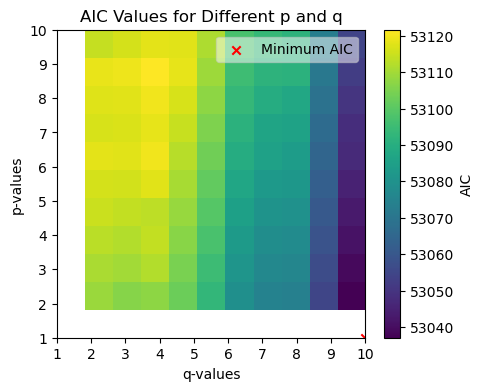

In [9]:
# Plot heatmap of AIC values
plt.figure(figsize=(5, 4))
plt.imshow(aic_values, origin='lower', cmap='viridis', extent=[1, n-1, 1, n-1])
plt.colorbar(label='AIC')
plt.title('AIC Values for Different p and q')
plt.xlabel('q-values')
plt.ylabel('p-values')
plt.xticks(range(1, n))
plt.yticks(range(1, n))
plt.scatter(min_aic_index[1], min_aic_index[0], marker='x', color='red', label='Minimum AIC')
legend = plt.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

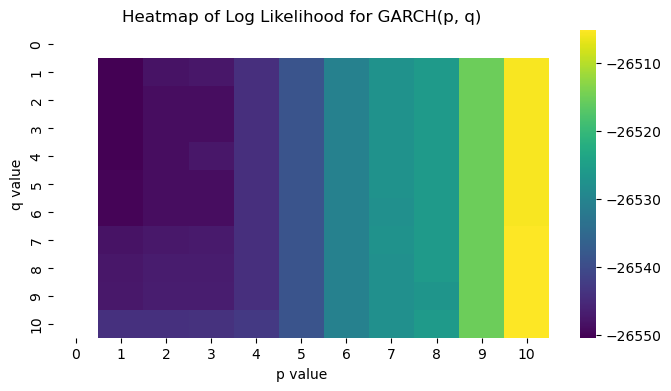

In [10]:
# Plotting the heatmap of log likelihood
plt.figure(figsize=(8, 4))
sns.heatmap(log_likelihoods, annot=True, fmt=".2f", cmap="viridis", xticklabels=range(11), yticklabels=range(11))
plt.title('Heatmap of Log Likelihood for GARCH(p, q)')
plt.xlabel('p value')
plt.ylabel('q value')
plt.show()

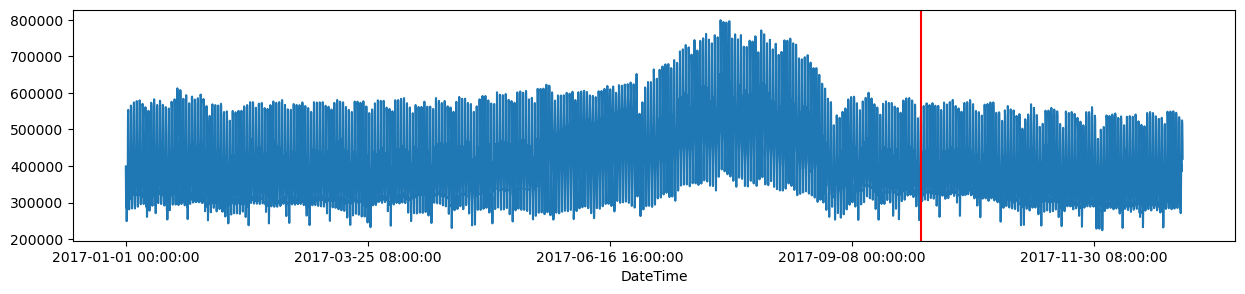

In [134]:
morocco['Consumption'].plot(figsize=(15,3))
plt.axvline(x=6575, color='red') # line where we split between train/test set

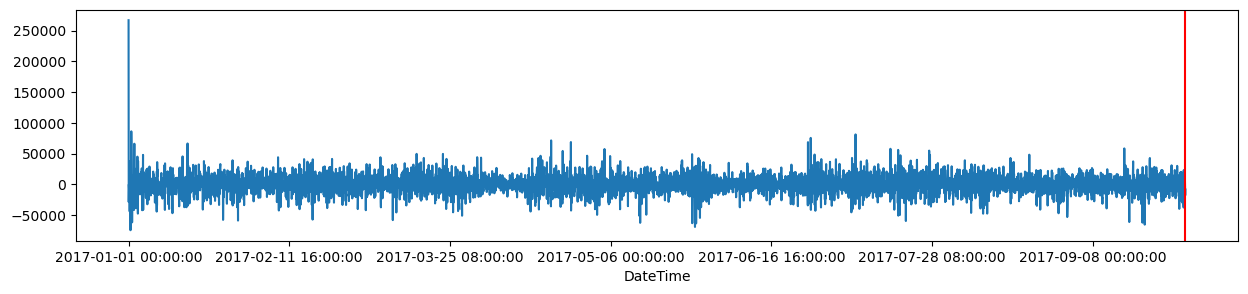

In [135]:
residuals.plot(figsize=(15,3))
plt.axvline(x=6575, color='red') # line where we split between train/test set

#### Prepare data with conditional volatility

In order to use the conditional volatility from the GARCH model, you can combine the forecasts from both models to obtain a more accurate and robust prediction of future values. There are several ways to combine the forecasts:
* Simple average: One straightforward method is to take the simple average of the forecasts from the SARIMAX and GARCH models. This approach assumes that both models contribute equally to the forecast and can be effective when the models have similar performance.
* Weighted average: Instead of giving equal weight to each model, you can assign weights based on the relative performance or confidence in each model. For example, you could use cross-validation or validation set performance metrics to determine the weights for each model.
* Model stacking: Model stacking involves using a meta-model to learn how to combine the forecasts from multiple models. In this approach, you train a separate meta-model (e.g., linear regression, random forest) using the forecasts from SARIMAX and GARCH models as features and the actual target values as the target variable. The meta-model learns how to combine the forecasts to minimize prediction error.
* Ensemble method: Ensemble methods combine forecasts from multiple models using techniques such as bagging, boosting, or random forests. These methods aim to reduce prediction error by leveraging the diversity of the individual models' predictions.
* Dynamic model combination: Dynamic model combination involves updating the weights or combining rules over time based on the recent performance of each model. This approach allows the combination strategy to adapt to changes in the data or model performance.

Model stacking:  
The strategy you described, where you use predictions from SARIMAX and conditional volatility from GARCH as exogenous features for prediction using an XGBoost (XGB) model, can be termed as a "feature engineering" or "model stacking" approach.

Feature Engineering: You're creating new features (predictions from SARIMAX and conditional volatility from GARCH) based on the output of other models (SARIMAX and GARCH) to enhance the predictive power of your XGBoost model. This is a common practice in machine learning, where feature engineering aims to provide the model with more relevant information to improve its performance.
Model Stacking: You're combining predictions from multiple models (SARIMAX, GARCH) with your primary predictive model (XGBoost) to leverage the strengths of each model and potentially achieve better predictive accuracy. This is similar to model stacking, where predictions from base models are used as features for a meta-model to further refine predictions.

Ensemble:  
Using ensemble methods involves combining predictions from multiple models to make a final prediction. Ensemble methods aim to improve predictive performance by leveraging the diversity of individual models and aggregating their predictions in a way that reduces prediction error. Here's how you can use ensemble methods with SARIMAX, GARCH, and XGBoost models:
1. Obtain predictions from each model
2. Combine predictions using an ensemble method (Majority voting for classification, averaging for regression, weighted average, stacking)
3. Evaluate with validation set or cross-validation
4. Compare results with individual models

In [110]:
print(print(conditional_volatility.shape))

NameError: name 'conditional_volatility' is not defined

In [18]:
%%time
# Set up the conditional volatility for the train set
sarimax_train = create_sarimax_model(y_train.diff().dropna(), X_train.diff().dropna(), order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)
garch_model_trainset = arch_model(sarimax_train.resid, p=1, q=1, mean='zero', vol='Garch', dist='normal', rescale=True)
garch_result_trainset = garch_model_trainset.fit(disp='off', update_freq=5)

# Set up the conditional volatility for the test set
sarimax_test = create_sarimax_model(y_test.diff().dropna(), X_test.diff().dropna(), order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)
garch_model_testset = arch_model(sarimax_test.resid, p=1, q=1, mean='zero', vol='Garch', dist='normal', rescale=True)
garch_result_testset = garch_model_testset.fit(disp='off', update_freq=5)

conditional_volatility_X_train = garch_result_trainset.conditional_volatility
conditional_volatility_X_test = garch_result_testset.conditional_volatility

#print(conditional_volatility_X_train.shape)
#print(X_train.shape)
#print(conditional_volatility_X_test.shape)
#print(X_test.shape)

X_train_vol = pd.DataFrame({'Temperature': X_train.squeeze(), 'conditional_volatility': conditional_volatility_X_train}, index=X_train.index)
#np.concatenate((X_train, conditional_volatility_X_train.values))
X_test_vol = pd.DataFrame({'Temperature': X_test.squeeze(), 'conditional_volatility': conditional_volatility_X_test}, index=X_test.index)
#np.concatenate((X_test, conditional_volatility_X_test.values))


#print(X_train_vol.shape)
#print(X_test_vol.shape)

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


CPU times: user 8.08 s, sys: 3.13 s, total: 11.2 s
Wall time: 7.37 s


In [19]:
%%time
def create_xgb_model():
    model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=seed)
    return model

xgb_model = create_xgb_model()
xgb_model = xgb_model.fit(X_train_vol, y_train) # conditional volatility

CPU times: user 1.19 s, sys: 538 ms, total: 1.73 s
Wall time: 246 ms


In [20]:
print('XGB with conditional volatility')

xgb_y_pred = xgb_model.predict(X_test_vol)

xgb_mape = mean_absolute_percentage_error(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)
print(f'{dataset_name}, MAE: {xgb_mae:.2f}, MAPE: {xgb_mape:.3f}, R2: {xgb_r2:.3f}')

n = len(y_test)
k = X_test.shape[0] + 1  # Number of parameters including intercept (difference between shape[0], and [1]?)
log_likelihood = -0.5 * n * np.log(2 * np.pi * xgb_mae) - n * np.log(xgb_mae)  # Assuming normal distribution for errors
aic_value = 2 * k - 2 * log_likelihood
bic_value = np.log(n) * k - 2 * log_likelihood
print(f'AIC: {aic_value:.2f}, BIC: {bic_value:.2f}')

XGB with conditional volatility
morocco, MAE: 67955.60, MAPE: 0.181, R2: 0.025
AIC: 80392.25, BIC: 92662.11


XGB with conditional volatility: using garch(1,1) without differenced data and s=7:
* morocco, MAE: 70544.46, MAPE: 0.193, R2: -0.042
* AIC: 80634.52, BIC: 92904.39

XGB with conditional volatility: using garch(1,1) without differenced data and s=24:
* morocco, MAE: 72952.68, MAPE: 0.201, R2: -0.086
* AIC: 80852.04, BIC: 93121.91

XGB with conditional volatility: using garch(1,1) with differenced data and s=24:
* LU decomposition error - enforce_stationarity=False, I am using differenced data anyways
* morocco, MAE: 67955.60, MAPE: 0.181, R2: 0.025
* AIC: 80392.25, BIC: 92662.11

In [ ]:
def fitting_and_eval(features, target, dataset_name, model_file_identifier='_', lookback = 48):
    # split_and_scale: Test set is the last 90 days
    #X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=2160, random_state=seed, shuffle=False)
    
    # Scale X data
    if False:
        XScaler = StandardScaler()
        XScaler.fit(X_train)
        X_train_scaled = XScaler.transform(X_train)
        X_test_scaled = XScaler.transform(X_test)

    # Scale Y data
    if False:
        YScaler = StandardScaler()
        YScaler.fit(y_train.values.reshape(-1, 1))
        y_train_scaled = YScaler.transform(y_train.values.reshape(-1, 1))
        y_test_scaled = YScaler.transform(y_test.values.reshape(-1, 1))
    
    # Variables
    #n_steps = lookback # hours
    #learning_rate
    #max_depth
    #n_estimators
    #subsample
    
    #model_file_path = os.path.join('../models', model_file_identifier, dataset_name)
    #print(model_file_path)
    #if os.path.exists(model_file_path):  # Check if the model file exists
    #    model = xgb.Booster(model_file=model_file_path)  # Load the model
    #else:
    #    n_features = X_train.shape[1]
    xgb_model = create_xgb_model()#X_train, X_test, y_train, y_test)
    #    model.save_model(model_file_path)
    
    # evaluate the model on the test set
    y_pred = xgb_model.predict(X_test)
    #y_pred = YScaler.inverse_transform(y_pred_scaled)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{dataset_name}, MAE: {mae:.2f}, MAPE: {mape:.3f}, R2: {r2:.3f}')
    
    n = len(y_test)
    k = X_test.shape[1] + 1  # Number of parameters including intercept
    log_likelihood = -0.5 * n * np.log(2 * np.pi * mae) - n * np.log(mae)  # Assuming normal distribution for errors
    aic_value = 2 * k - 2 * log_likelihood
    bic_value = np.log(n) * k - 2 * log_likelihood
    print(f'AIC: {aic_value:.2f}, BIC: {bic_value:.2f}')

    return r2, mae, mape, X_test, y_test, y_pred

In [ ]:
%%time
#print('XGB with conditional volatility')

#data = morocco.dropna().reset_index(drop=True)
#X = data[['conditional_volatility', 'Temperature']].to_numpy()#.values
#y = data['Consumption']#.to_numpy()#.values

#lookback=48 # 2 days

# ARMA: add more exogenous variables?
#model_file_identifier = 'xgb_volatility' + '_' + str(lookback)
#r2, mae, mape, X_test, y_test, xgb_pred = fitting_and_eval(X, y, 'morocco', model_file_identifier=model_file_identifier, lookback=lookback)

### Ensemble model
We will now compare the Sarimax results with an ensemble model using the predictions from the sarimax model as one feature and the predictions from the garch+xgb model as another feature. These features will be added with the other energy data.

In [ ]:
# I want to use X_test as the new X as it contains the data for the 90 days
# Therefore y_test will become the new y as it also contains the actual 90 days.
# I want to use this new X and y to create a new train_test_split of 50% test size
# 50% in order to predict the next 45 days

In [ ]:
print(X_test.shape)
print(xgb_pred.shape)
print(sarimax_y_pred.shape)
print(X_test_with_pred.shape)
print(y_test.shape)

In [ ]:
xgb_y_pred.shape

In [26]:
# Use predictions as a feature for SVM
#X_test_with_pred = np.hstack((X_test, xgb_pred, sarimax_y_pred))
svm_X = result_df = pd.DataFrame(
    {'X_test': X_test.values,
     'xgb_pred': xgb_y_pred,
     'sarimax_y_pred': sarimax_y_pred.values},
    index=X_test.index
)
svm_y = y_test

#Create a new train-test split with 50% test size (45 days)
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X, svm_y, test_size=0.5, random_state=seed)
print(svm_X_train.shape)
print(svm_X_test.shape)
print(svm_y_train.shape)
print(svm_y_test.shape)

(1080, 3)
(1080, 3)
(1080,)
(1080,)


In [32]:
print('SARIMAX Mape', mean_absolute_percentage_error(y_test, sarimax_y_pred))
print('XGB Mape', mean_absolute_percentage_error(y_test, xgb_y_pred))

print('SARIMAX MAE', mean_absolute_error(y_test, sarimax_y_pred))
print('XGB Mape', mean_absolute_error(y_test, xgb_y_pred))

SARIMAX Mape 0.7670208528542172
XGB Mape 0.18095567555644262
SARIMAX MAE 301643.74245634145
XGB Mape 67955.6018153588


In [27]:
# Train SVM model
svm_model = SVR()
svm_model.fit(svm_X_train, svm_y_train)

svm_y_pred = svm_model.predict(svm_X_test)
    
# Calculate metrics for SVM model
svm_mape = mean_absolute_percentage_error(svm_y_test, svm_y_pred)
svm_mae = mean_absolute_error(svm_y_test, svm_y_pred)
svm_r2 = r2_score(svm_y_test, svm_y_pred)

print(f'morocco, MAE: {svm_mae:.2f}, MAPE: {svm_mape:.3f}, R2: {svm_r2:.3f}')

# Compute AIC and BIC for SVM model
n = len(y_test)
k = svm_X_train.shape[1] + 1  # Number of parameters including intercept
log_likelihood = -0.5 * n * np.log(2 * np.pi * svm_mae) - n * np.log(svm_mae)  # Assuming normal distribution for errors
aic_value = 2 * k - 2 * log_likelihood
bic_value = np.log(n) * k - 2 * log_likelihood
print(f'SVM Model - AIC: {aic_value:.2f}, BIC: {bic_value:.2f}')

morocco, MAE: 68922.66, MAPE: 0.182, R2: 0.000
SVM Model - AIC: 76169.81, BIC: 76192.52


Previous run:
* morocco, MAE: 68860.90, MAPE: 0.182, R2: 0.002  
* SVM Model - AIC: 76164.00, BIC: 76186.71

Using the predictions from the last configured sarimax model:
* morocco, MAE: 68901.35, MAPE: 0.182, R2: 0.001
* SVM Model - AIC: 76167.81, BIC: 76190.52

Using the predictions from the "best" sarimax model:
* morocco, MAE: 68922.66, MAPE: 0.182, R2: 0.000
* SVM Model - AIC: 76169.81, BIC: 76192.52

In [ ]:
#['Consumption', 'Temperature', 'sarimax_prediction', 'xgb_prediction']

### Diagnostics
Residuals Analysis: Check if residuals of each model are white noise (no autocorrelation). (check using ACF and PACF of the residuals).  
Volatility Clustering: Ensure there is no pattern in the squared residuals. For the GARCH model, ensure that there is no remaining autocorrelation in the squared residuals, indicating a good fit of the volatility model.  
Information Criteria: Lower AIC or BIC values indicate a better model fit.

### Model comparison
table with results:

Out-of-Sample Forecasting: Compare how each model performs on the testing dataset. Evaluate the forecasting accuracy using measures like RMSE, MAE, or others suitable for volatility models like MAPE.

Forecast Accuracy: Compare the forecast accuracy of the ARMA model for the mean level of energy consumption using metrics like RMSE, MAE, etc.

Volatility Forecasting: Evaluate the GARCH model's ability to capture the changing variance in the forecast period. Use metrics suitable for comparing volatility forecasts.

Often, combining these models provides a more comprehensive analysis by capturing both the mean and volatility dynamics. Fit an ARMA-GARCH model where ARMA captures the conditional mean and GARCH models the conditional variance.

Model Fit and Forecasting: Assess the combined model's performance on both the historical fit and its forecasting ability.

### Statistics
Parameter Significance: Check the statistical significance of the model parameters.  
Economic Evaluation: Consider the economic implications of the models' results (e.g., in risk management).

### Results
Compile your findings, detailing the model specifications, estimation results, diagnostic checks, and out-of-sample forecasting comparisons. Highlight strengths and weaknesses of each model in context to your specific application.

### Practical use
Application to Risk Management: Understand the implications of volatility in energy consumption, such as for budgeting and risk management in energy supply.  

Policy and Planning: Use the insights from the models for energy policy making and infrastructure planning.